In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


In [46]:
!cp /content/drive/MyDrive/ML/diabetes.csv /content/drive/MyDrive/ML/wine-reviews.csv /content/

In [47]:
df = pd.read_csv("/content/wine-reviews.csv", usecols = ['country','description','points','price','variety','winery'])

In [48]:
df.head

<bound method NDFrame.head of          country                                        description  points  \
0          Italy  Aromas include tropical fruit, broom, brimston...      87   
1       Portugal  This is ripe and fruity, a wine that is smooth...      87   
2             US  Tart and snappy, the flavors of lime flesh and...      87   
3             US  Pineapple rind, lemon pith and orange blossom ...      87   
4             US  Much like the regular bottling from 2012, this...      87   
...          ...                                                ...     ...   
129966   Germany  Notes of honeysuckle and cantaloupe sweeten th...      90   
129967        US  Citation is given as much as a decade of bottl...      90   
129968    France  Well-drained gravel soil gives this wine its c...      90   
129969    France  A dry style of Pinot Gris, this is crisp with ...      90   
129970    France  Big, rich and off-dry, this is powered by inte...      90   

        price        

In [49]:
df = df.dropna(subset=["description","points"])

In [50]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


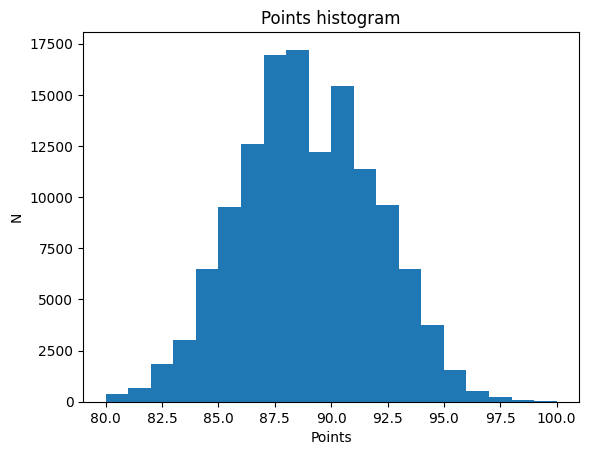

In [51]:
plt.hist(df.points,bins=20)
plt.title("Points histogram")
plt.ylabel("N")

plt.xlabel("Points")
plt.show()

In [52]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description","points","label"]]

In [53]:
df.head()


,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


In [54]:
df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [55]:
df = df[["description","label"]]

In [56]:
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [57]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [58]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [59]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)


In [60]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Benton-Lane makes quite a lot of Pinot Gris, stainless-steel fermented and whole cluster pressed, yielding a soft, fragrant, fruity wine with plenty of fresh pear flavor. It flattens out broadly across the palate, full-bodied and lightly spicy. Just a bit more focus would really elevate this wine to the top ranks.',
        b'Menthol and eucalyptus dominate over the indistinguishable fruit in this full-bodied, thick wine.',
        b'This celebration of Tannat is a balanced while severe and structured wine. Plenty of juicy fruit is ready to come out from behind the dry, tannic structure. There is power here as well in this wine that is firm and needs to age. Drink from 2019.',
        ...,
        b'The wine comes from a 14-acre estate owned by the producer. Its fruitiness and texture are both important elements in the wine at this young stage. They give a tightly textured wine that is still bright, crisp with lemon fruit and c

In [61]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string,trainable=True)

In [62]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.20037231, -0.13899669, -0.15803906, ..., -0.1799071 ,
         0.08406892, -0.0184364 ],
       [ 0.29010034, -0.37525433, -0.07067482, ...,  0.06103001,
        -0.19107711,  0.00378342],
       [ 0.4205897 , -0.19257516, -0.07901622, ..., -0.2277292 ,
        -0.13105778,  0.08544849],
       ...,
       [ 0.40782997, -0.03508495,  0.14863586, ...,  0.07873158,
        -0.07309233, -0.00754348],
       [ 0.61128885, -0.25113952, -0.12209625, ...,  0.06084976,
        -0.10689511, -0.05688743],
       [ 0.504732  , -0.07388993,  0.28212023, ...,  0.0587374 ,
         0.09712046, -0.025058  ]], dtype=float32)>

In [63]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))


In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [65]:
model.evaluate(train_data)

102/102 [==============================] - 1s 10ms/step - loss: 0.6976 - accuracy: 0.4166


[0.6975951194763184, 0.41664421558380127]

In [66]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 9ms/step - loss: 0.6979 - accuracy: 0.4188


[0.6978893280029297, 0.41878893971443176]

In [67]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 80s 774ms/step - loss: 0.6550 - accuracy: 0.6203 - val_loss: 0.5315 - val_accuracy: 0.7789
Epoch 2/5
102/102 [==============================] - 65s 639ms/step - loss: 0.4829 - accuracy: 0.7861 - val_loss: 0.4012 - val_accuracy: 0.8180
Epoch 3/5
102/102 [==============================] - 65s 642ms/step - loss: 0.3993 - accuracy: 0.8332 - val_loss: 0.3782 - val_accuracy: 0.8244
Epoch 4/5
102/102 [==============================] - 66s 651ms/step - loss: 0.3646 - accuracy: 0.8496 - val_loss: 0.3725 - val_accuracy: 0.8297
Epoch 5/5
102/102 [==============================] - 65s 638ms/step - loss: 0.3411 - accuracy: 0.8617 - val_loss: 0.3736 - val_accuracy: 0.8300


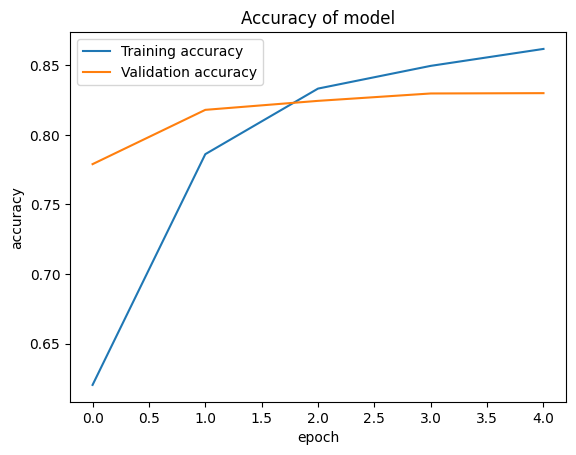

In [68]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Accuracy of model")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

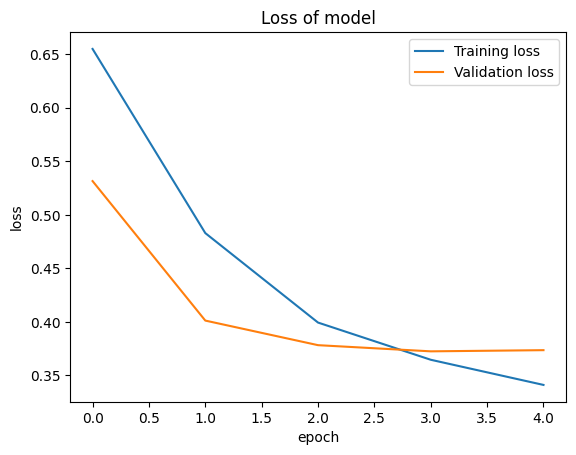

In [69]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [70]:
model.evaluate(test_data)

13/13 [==============================] - 1s 85ms/step - loss: 0.3822 - accuracy: 0.8274


[0.3822062015533447, 0.8274350166320801]

#LSTM

In [71]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text,label:text))

In [72]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [73]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [75]:
model.evaluate(train_data)
model.evaluate(test_data)


13/13 [==============================] - 1s 105ms/step - loss: 0.6931 - accuracy: 0.5115


[0.6931115388870239, 0.5115402340888977]

In [78]:
history = model.fit(train_data,epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 37s 363ms/step - loss: 0.3693 - accuracy: 0.8337 - val_loss: 0.3501 - val_accuracy: 0.8389
Epoch 2/5
102/102 [==============================] - 34s 337ms/step - loss: 0.3488 - accuracy: 0.8449 - val_loss: 0.3542 - val_accuracy: 0.8403
Epoch 3/5
102/102 [==============================] - 34s 337ms/step - loss: 0.3448 - accuracy: 0.8458 - val_loss: 0.3433 - val_accuracy: 0.8434
Epoch 4/5
102/102 [==============================] - 33s 325ms/step - loss: 0.3375 - accuracy: 0.8483 - val_loss: 0.3451 - val_accuracy: 0.8445
Epoch 5/5
102/102 [==============================] - 32s 315ms/step - loss: 0.3348 - accuracy: 0.8497 - val_loss: 0.3479 - val_accuracy: 0.8413


In [79]:
model.evaluate(test_data)

13/13 [==============================] - 1s 108ms/step - loss: 0.3633 - accuracy: 0.8311


[0.3633172810077667, 0.8310509324073792]